########################################################
### This file is used to generate Table 4-5, Fig 3-4 ###
########################################################

- [Forward Problem](#Forward-Problem)
    - [Verify Assumption 1](#Verify-Assumption-1)
        - [Table 7](#Table-7)
        - [Table 8](#Table-8)
    - [Verify Lemma 1](#Verify-Lemma-1)
        - [Left plot in Figure 4](#Left-plot-in-Figure-4)
    - [Verify Theorem 3.1](#Verify-Theorem-3.1)
        - [Right plot in Figure 4](#Right-plot-in-Figure-4)
- [Inverse Problem](#Inverse-Problem)
    - [Verify Assumption 2](#Verify-Assumption-2)
    - [Verify Theorem 4.2](#Verify-Theorem-4.2)
        - [Figure 5](#Figure-5)

<font color=red>**Note(Important!!!!!)** 
Since this file would require data from Data directory, you will need to generate the data files, there are two ways to generate the data.</font>

- Way 1: run 'GenerateData.ipynb' to get QoI values at quadrature points in order to get coefficients in PCE; and all the ratio evaluations
- Way 2: run 'GenerateData_ParallelVersion.ipynb' and set multiple processors

In [1]:
import os
import scipy.io as sio #for the i/o
import numpy as np
import numpy.polynomial.hermite_e as H 
from math import factorial
from scipy.stats import norm
from scipy.stats import gaussian_kde as kde
from matplotlib import pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

%matplotlib inline

In [2]:
####### Plot Formatting ######
plt.rc('lines', linewidth = 2)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend',fontsize=14)
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.figsize'] = (8.0, 6.0)

Problem:

\begin{align*}
- \nabla\cdot(A\nabla u) &= (e^{\lambda_1}\lambda_1^2\pi^2 + e^{\lambda_2}\lambda_2^2\pi^2)u \\
u &= 0 \, \text{ on } \Gamma_0 \,\text{(   Left edge)}\\
(A\nabla u)\cdot n &= -e^{\lambda_2}\lambda_2\pi \sin\lambda_1\pi x\sin \lambda_2\pi y \, \text{ on } \Gamma_1  \, \text{(   Top edge)}\\
(A\nabla u)\cdot n &= e^{\lambda_2}\lambda_2\pi \sin\lambda_1\pi x\sin \lambda_2\pi y \, \text{ on } \Gamma_2  \,\text{(   Bottom edge)}\\
(A\nabla u)\cdot n &= e^{\lambda_1}\lambda_1\pi \cos\lambda_1\pi x\cos \lambda_2\pi y \, \text{ on } \Gamma_3  \,\text{(   Right edge)}\\
\end{align*}

where 
$$ A = \begin{bmatrix} e^{\lambda_1} & 0 \\ 0 & e^{\lambda_2} \end{bmatrix} $$
and $\Omega = [0,1]\times [0,1]$.

<font color = red>**Exact solution:**
$$ u = \sin \lambda_1\pi x \cos \lambda_2 \pi y$$
</font>

QoI is:
 
\begin{align*}
Q(\lambda_1,\lambda_2) &=  \frac{1}{(b-a)(d-c)}\int_{c}^{d} \int_{a}^{b} u(x,y,\lambda_1,\lambda_2)\, dx\, dy \\
&= \frac{1}{(b-a)(d-c)} \int_{a}^{b} \sin \lambda_1\pi x \, dx \int_{c}^{d} \cos \lambda_2 \pi y \, dy\\
&= \frac{1}{(b-a)(d-c)} \left( \frac{\cos \lambda_1\pi a - \cos\lambda_1\pi b}{\lambda_1\pi}\right) \left( \frac{\sin \lambda_2\pi d - \sin \lambda_2\pi c}{\lambda_2\pi}\right) \\
&= \frac{(\cos \lambda_1\pi a - \cos\lambda_1\pi b)(\sin \lambda_2\pi d - \sin\lambda_2\pi c) }{(b-a)(d-c)\lambda_1\lambda_2\pi^2} 
\end{align*}


### When standard normal
</font >

$$ \Phi_{ij}(x,y) = \Phi_i(x) \Phi_j(y)$$

$$ (\Phi_{ij}, \Phi_{kl}) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \Phi_{ij}(x,y)\Phi_{kl}(x,y) e^{-\frac{x^2+y^2}{2}}\, dx\, dy = (\sqrt{2\pi})^2 i! j! \delta_{ik}\delta_{jl}$$


$$ Q(\lambda_1, \lambda_2) = \sum_{i,j=0}^{\infty} q_{ij} \Phi_{ij}(\lambda_1,\lambda_2)$$

$$ q_{ij} = \frac{1}{(\Phi_{ij},\Phi_{ij})} \biggr(Q(\lambda_1, \lambda_2), \  \Phi_{ij}(\lambda_1,\lambda_2)\biggr) = \frac{1}{(\sqrt{2\pi})^2 i! j! } \biggr(Q(\lambda_1, \lambda_2), \  \Phi_{ij}(\lambda_1,\lambda_2)\biggr)$$

**Gauss-Hermite Quadrature**
 
\begin{align*}
\biggr(Q(\lambda_1, \lambda_2), \  \Phi_{ij}(\lambda_1,\lambda_2)\biggr) &= \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} Q(\lambda_1,\lambda_2) \Phi_i(\lambda_1) e^{-\frac{\lambda_1^2}{2}} \, d\lambda_1 \Phi_j(\lambda_2) e^{-\frac{\lambda_2^2}{2}} \, d\lambda_2\\
&= \int_{-\infty}^{\infty} \biggr( \sum_{k=1}^n w_k Q(\lambda_1^{(k)}, \lambda_2)\Phi_i(\lambda_1^{(k)}) \biggr) \Phi_j(\lambda_2) e^{-\frac{\lambda_2^2}{2}} \, d\lambda_2\\ 
&= \sum_{l=1}^n  w_l \biggr( \sum_{k=1}^n w_k Q(\lambda_1^{(k)}, \lambda_2^{(l)})\Phi_i(\lambda_1^{(k)}) \biggr) \Phi_j(\lambda_2^{(l)})
\end{align*}

### When generalized normal

**Quadrature Rule**

<font color = red>
If 
$$ \int_{-\infty}^{\infty} f(x) e^{-\frac{x^2}{2}}\, dx \approx \sum_{i=1}^n w_if(x_i)$$
we will have
$$ \int_{-\infty}^{\infty} f(x) e^{-\frac{(x-\mu)^2}{2\sigma^2}}\, dx \approx \sigma \sum_{i=1}^n w_if(\mu + \sigma x_i)$$
</font >

If $\lambda_1$, $\lambda_2$ don't follow standard normal $N(0,1)$, assume $\lambda_1\sim N(\mu_1, \sigma_1^2)$, $\lambda_2\sim N(\mu_2, \sigma_2^2)$, we will have 

$$ Q(\lambda_1, \lambda_2) = \sum_{i,j=0}^{\infty} q_{ij} \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)$$



Still use above $\Phi_{ij}$, but in order to make it orthogonal, we should have basis like

$$ \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right) $$

then 

\begin{align*}
&\,\,\, \left(  \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right),  \Phi_{kl}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)  \right)\\
&= \left(  \Phi_{i}\left(\frac{\lambda_1 - \mu_1}{\sigma_1}\right)\Phi_{j}\left(\frac{\lambda_2 - \mu_2}{\sigma_2}\right),  \Phi_{k}\left(\frac{\lambda_1 - \mu_1}{\sigma_1}\right) \Phi_l\left(\frac{\lambda_2 - \mu_2}{\sigma_2}\right)  \right)\\
&= \int_{R} \int_{R} \Phi_{i}\left(\frac{\lambda_1 - \mu_1}{\sigma_1}\right)\Phi_{j}\left(\frac{\lambda_2 - \mu_2}{\sigma_2}\right)  \Phi_{k}\left(\frac{\lambda_1 - \mu_1}{\sigma_1}\right) \Phi_l\left(\frac{\lambda_2 - \mu_2}{\sigma_2}\right)e^{-\frac{(\lambda_1-\mu_1)^2}{2\sigma_1^2}} e^{-\frac{(\lambda_2-\mu_2)^2}{2\sigma_2^2}} d\lambda_1 d\lambda_2 \\
&= \sigma_1\sigma_2 \int_{R} \int_{R} \Phi_{i}(y_1)\Phi_j(y_2)\Phi_{k}(y_1)\Phi_l(y_2) e^{-\frac{y_1^2}{2}}e^{-\frac{y_2^2}{2}}\, dy_1\, dy_2 \\
&= \sigma_1\sigma_2 2\pi i! j! \delta_{ik}\delta_{jl}
\end{align*}


Since 
$$ Q(\lambda_1, \lambda_2) = \sum_{i,j=0}^{\infty} q_{ij} \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)$$
then
 
\begin{align*}
q_{ij} &= \frac{1}{\left(\Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right),\Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)\right)} \biggr(Q(\lambda_1, \lambda_2), \  \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)\biggr) \\
&= \frac{1}{\sigma_1 \sigma_2 2\pi i! j! } \biggr(Q(\lambda_1, \lambda_2), \  \Phi_{ij}\left(\frac{\lambda_1 - \mu_1}{\sigma_1},\frac{\lambda_2 - \mu_2}{\sigma_2}\right)\biggr)\\
&= \frac{1}{\sigma_1 \sigma_2 2\pi i! j! } \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} Q(\lambda_1,\lambda_2) \Phi_i\left(\frac{\lambda_1-\mu_1}{\sigma_1}\right) e^{-\frac{(\lambda_1-\mu_1)^2}{2\sigma_1^2}} \, d\lambda_1 \Phi_j\left(\frac{\lambda_2-\mu_2}{\sigma_2}\right) e^{-\frac{(\lambda_2-\mu_2)^2}{2\sigma_2^2}} \, d\lambda_2\\
&= \frac{1}{\sigma_1 \sigma_2 2\pi i! j! } \int_{-\infty}^{\infty} \sigma_1 \biggr( \sum_{k=1}^n w_k Q(\mu_1+\sigma_1\lambda_1^{(k)}, \lambda_2)\Phi_i(\lambda_1^{(k)}) \biggr) \Phi_j\left(\frac{\lambda_2 - \mu_2}{\sigma_2}\right) e^{-\frac{(\lambda_2-\mu_2)^2}{2\sigma_2^2}} \, d\lambda_2\\ 
&= \frac{1}{\sigma_1 \sigma_2 2\pi i! j! } \sigma_2 \sum_{l=1}^n  w_l \sigma_1 \biggr( \sum_{k=1}^n w_k Q(\mu_1+\sigma_1\lambda_1^{(k)}, \mu_2+\sigma_2\lambda_2^{(l)})\Phi_i(\lambda_1^{(k)}) \biggr) \Phi_j(\lambda_2^{(l)})\\
&= \frac{1}{2\pi i! j! } \sum_{l=1}^n  w_l \biggr( \sum_{k=1}^n w_k Q(\mu_1+\sigma_1\lambda_1^{(k)}, \mu_2+\sigma_2\lambda_2^{(l)})\Phi_i(\lambda_1^{(k)}) \biggr) \Phi_j(\lambda_2^{(l)})
\end{align*}

Assume 
$$ \lambda_1 \sim N(\mu_1, \sigma_1^2) = N(0, 0.1^2) \ \ \ \lambda_2 \sim N(\mu_2, \sigma_2^2) = N(0, 0.1^2) $$

In [3]:
proc_size = 25   # this number is determined by the number of data files

In [4]:
mu1 = 0
mu2 = 0
sigma1 = 0.1
sigma2 = 0.1

## Get $Q_n(\lambda_1,\lambda_2)$ (need to compute coef $q_{ij}$)

In [5]:
def Hermite_2d(i,j,x,y):
    '''
    Phi_{i,j}(x,y) = Phi_i(x) * Phi_j(y)  (left: 2d; right: 1d)
    '''
    c = np.zeros((20,20))
    c[i,j] = 1
    return H.hermeval2d(x, y, c)
 
Q_FEM_quad = np.zeros(int(400))   #already include information of mu1, mu2, sigma1, sigma2
for i in range(proc_size):          
    filename = os.path.join(os.getcwd(), "Data", "Q_FEM_quad_") + str(i) + ".mat"
    partial_data = sio.loadmat(filename)
    Q_FEM_quad += partial_data['Q_FEM'].reshape(int(400))

def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def q(i,j):
    '''
    copmute coefficient q_{ij}    
    Set up Gauss-Hermite quadrature, weighting function is exp^{-x^2}
    '''
    x, w=H.hermegauss(20)     
    Q=sum([w[ldx]*sum([w[kdx] * Q_FEM_quad[ldx*20+kdx] * H.hermeval(x[kdx],Phi(i)) for kdx in range(20)])*H.hermeval(x[ldx],Phi(j)) for ldx in range(20)])     
    q= Q/(2*np.pi*factorial(i)*factorial(j))
    
    return q

qij = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        qij[i,j] = q(i,j)
        
def Q(n,x,y):
    result = 0 
    for i in range(n+1):
        for j in range(n+1):
            if i+j <=n:
                result += qij[i,j]*Hermite_2d(i,j,(x-mu1)/sigma1,(y-mu2)/sigma2)
    return result

def Qexact(x,y,a=0.4,b=0.6,c=0.4,d=0.6):
    sol = (np.cos(x*np.pi*a)-np.cos(x*np.pi*b))*(np.sin(y*np.pi*d)-np.sin(y*np.pi*c))/((b-a)*(d-c)*x*y*np.pi**2)
    return sol

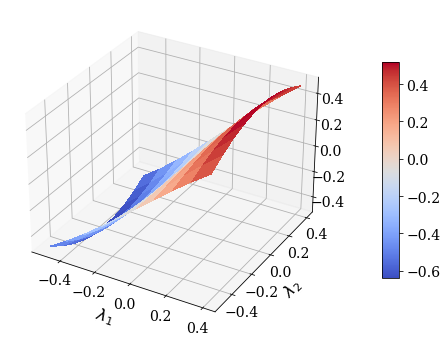

In [6]:
#Visualize the error between PCE and exact
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-0.5, 0.5, 0.1)
Y = np.arange(-0.5, 0.5, 0.1)
X, Y = np.meshgrid(X, Y)
# Z = Q(1, X, Y)
# Z = Q(5,X,Y) - Qexact(X,Y)
Z = Qexact(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.5, 0.5)        #Qexact zlim(-0.5,0.5); Qi-Q_exact zlim(-1.2,1.2)
ax.set_xlabel("$\lambda_1$", fontsize = 16)
ax.set_ylabel("$\lambda_2$", fontsize = 16)
ax.tick_params(direction='out', length=6, width=2, pad=1 ,colors='black',  \
               grid_color='r', grid_alpha=0.5, labelsize=14)    #pad:dist b/t label and axis
cbaxes = fig.add_axes([0.88, 0.25, 0.03, 0.5])     #1st:horizontal, 2&4th:vertical, 3rd:width
fig.colorbar(surf, shrink=5, aspect=14, cax=cbaxes)
plt.show()
# fig.savefig("images/2Q_exact_5std")   #2Q_exact_5std, 2Q1_5std

## Forward Problem
Assume 
$$ \lambda_1 \sim N(\mu_1, \sigma_1^2) = N(0, 0.1^2) \ \ \ \lambda_2 \sim N(\mu_2, \sigma_2^2) = N(0, 0.1^2) $$

### Verify Assumption 1

In [7]:
##### Generate data in Table 4 and 5 #####
def assumption1(n, J):
    np.random.seed(123456)
    lam1sample = np.random.normal(mu1, sigma1, J)
    lam2sample = np.random.normal(mu2, sigma2, J)
    pfprior_sample_n = Q(n, lam1sample, lam2sample)
    pfprior_dens_n = kde(pfprior_sample_n)
    x = np.linspace(-1, 1, 1000)
    return np.round(np.max(np.abs(np.gradient(pfprior_dens_n(x), x))), 2), np.round(np.max(pfprior_dens_n(x)), 2)


size_J = [int(1E3), int(1E4), int(1E5)]
degree_n = [1, 2, 3, 4, 5]
Bound_matrix, Lip_Bound_matrix = np.zeros((3, 5)), np.zeros((3, 5))
for i in range(3):
    for j in range(5):
        n, J = degree_n[j], size_J[i]
        Lip_Bound_matrix[i, j] = assumption1(n, J)[0]
        Bound_matrix[i, j] = assumption1(n, J)[1]

#### Table 7

In [8]:
###########################################
################ Table 7 ##################
###########################################
print('Table 7')
print('Bound under certain n and J values')
print(Bound_matrix)

Table 7
Bound under certain n and J values
[[2.63 2.63 2.61 2.61 2.61]
 [2.64 2.64 2.61 2.61 2.61]
 [2.6  2.6  2.57 2.57 2.57]]


#### Table 8

In [9]:
###########################################
################ Table 8 ##################
###########################################
print('Table 8')
print('Lipschitz bound under certain n and J values')
print(Lip_Bound_matrix)

Table 8
Lipschitz bound under certain n and J values
[[12.11 12.11 11.95 11.95 11.95]
 [11.47 11.47 11.41 11.41 11.41]
 [11.07 11.07 10.86 10.86 10.86]]


In [10]:
#### Use plot to show the difference between the exact pushforward and approximate pushforward #####
fig = plt.figure()
def plot_pushforward(n,J):
    #pfprior_dens = kde(Q_FEM)
    
    np.random.seed(123456)
    lam1sample = np.random.normal(mu1,sigma1,J)
    lam2sample = np.random.normal(mu2,sigma2,J)

    pfprior_sample = Qexact(lam1sample,lam2sample)
    pfprior_dens = kde(pfprior_sample)
    
    pfprior_sample_n = Q(n,lam1sample,lam2sample)
    pfprior_dens_n = kde(pfprior_sample_n)
    
    fig.clear()
    qplot = np.linspace(-1,1, num=1000)
        
    plt.plot(qplot,pfprior_dens(qplot),color='r', linestyle='-.', linewidth=4,label="$\pi_{\mathcal{D}}^{Q}$")
    plt.plot(qplot,pfprior_dens_n(qplot),label="$\pi_{\mathcal{D}}^{Q_n}$")
        
    plt.title('Lipschitz const. = %4.2f and Bound = %2.2f' %(np.max(np.abs(np.gradient(pfprior_dens_n(qplot), qplot))),
                                                                             np.max(pfprior_dens_n(qplot))))
    plt.legend()
    
interact(plot_pushforward, 
         n = widgets.IntSlider(value=int(1),min=int(1),max=int(5),step=1),
         J = widgets.IntSlider(value=int(1E3),min=int(1E3),max=int(1E5),step=int(1E3)))

<Figure size 576x432 with 0 Axes>

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), IntSlider(value=1000, description='J'…

<function __main__.plot_pushforward(n, J)>

### Verify Lemma 1
**Print out Monte Carlo Approximation of $	\|\pi_{\mathcal{D}}^Q(q)-\pi_{\mathcal{D}}^{Q_n}(q)\|_{L^r(\mathcal{D_c})} $ where $r>0$ and $D_c=[-1,1]$**

In [11]:
##### Generate data for the left plot of Fig 3 #####
# Define push-forward densities
N_kde = int(1E4)
N_mc = int(1E4)

np.random.seed(123456)
lam1sample = np.random.normal(mu1,sigma1,N_kde)
lam2sample = np.random.normal(mu2,sigma2,N_kde)
pfprior_dens = kde(Qexact(lam1sample,lam2sample))

def pfprior_dens_n(n,x):
    pfprior_sample_n =  Q(n,lam1sample,lam2sample)
    pdf = kde(pfprior_sample_n)
    return pdf(x)

In [12]:
# **Print out Monte Carlo Approximation of $	\|\pi_{\mathcal{D}}^Q(q)-\pi_{\mathcal{D}}^{Q_n}(q)\|_{L^r(\mathcal{D_c})} $ where $r>0$ and $D_c=[-1,1]$**
np.random.seed(123456)
qsample = np.random.uniform(-1,1,N_mc)

def error_r_onD(r,n):
    diff = (np.mean((np.abs(pfprior_dens_n(n,qsample) - pfprior_dens(qsample)))**r))**(1/r)
    return diff

error_r_D = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        error_r_D[i,j] = error_r_onD(i+1,j+1)

In [13]:
np.set_printoptions(linewidth=110) 
print('L^r error on data space for Forward Problem',end='\n\n')
print(error_r_D) 

L^r error on data space for Forward Problem

[[5.78985998e-03 5.78986860e-03 3.66465835e-05 3.66458716e-05 4.68447031e-06]
 [1.00098540e-02 1.00098559e-02 6.48003418e-05 6.48018329e-05 6.83125067e-06]
 [1.29985177e-02 1.29985144e-02 8.36155928e-05 8.36174583e-05 7.98012310e-06]
 [1.51923261e-02 1.51923210e-02 9.70172096e-05 9.70187251e-05 8.72619888e-06]
 [1.68583067e-02 1.68583012e-02 1.07115873e-04 1.07116859e-04 9.26298356e-06]]


In [14]:
#### To make it cleaner, create Directory "images" to store all the figures ####
imagepath = os.path.join(os.getcwd(),"images")
os.makedirs(imagepath,exist_ok=True)

#### Left plot in Figure 4

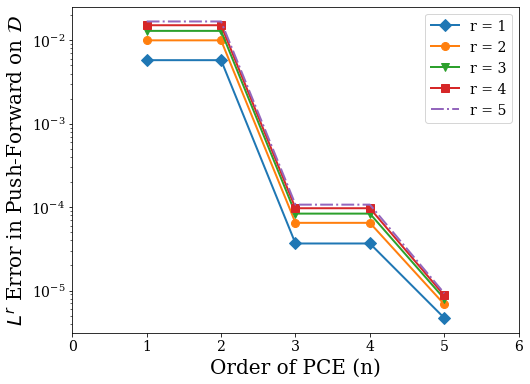

In [15]:
###########################################
######### The left plot of Fig 4 ##########
###########################################
fig = plt.figure()
plt.xlim([0,6])
marker = ['-D', '-o', '-v', '-s', '-.']
for i in range(5):
    plt.semilogy([1,2,3,4,5],error_r_D[i,:],marker[i],label='r = ' + np.str(i+1))    
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^r$'+' Error in Push-Forward on '+'$\mathcal{D}$')
plt.legend()
# fig.savefig("images/2forward_error_D")
plt.savefig("images/Fig4(Left).png")

### Verify Theorem 3.1
**Print out Monte Carlo Approximation of $	\|\pi_{\mathcal{D}}^Q(Q(\lambda))-\pi_{\mathcal{D}}^{Q_n}(Q_n(\lambda))\|_{L^2(\Lambda)} $**

In [16]:
##### Generate data for the right plot of Fig 4 #####
np.random.seed(123456)
lam1_seed = np.random.normal(mu1,sigma1,int(1E4))
lam2_seed = np.random.normal(mu2,sigma2,int(1E4))   #int(1E4) since Q_FEM size

error_2_Lam = np.zeros(5)
for i in range(5):
    pfprior_sample = Qexact(lam1_seed,lam2_seed)
    error_2_Lam[i] = (np.mean((np.abs(pfprior_dens_n(i+1,Q(i+1,lam1_seed,lam2_seed))\
                                      - pfprior_dens(pfprior_sample)))**2))**(1/2)   

In [17]:
np.set_printoptions(linewidth=110)   
print('L^2 error on parameter space for Forward Problem',end='\n\n')
print(error_2_Lam)  

L^2 error on parameter space for Forward Problem

[2.78836391e-02 2.78836376e-02 2.33315440e-04 2.33317057e-04 1.82851667e-05]


#### Right plot in Figure 4

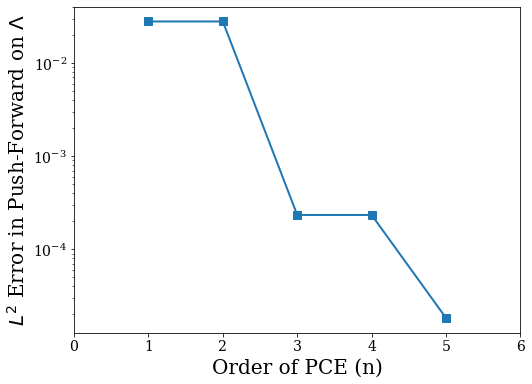

In [18]:
############################################
######### The right plot of Fig 4 ##########
############################################
fig = plt.figure()
plt.xlim([0,6])
plt.semilogy([1,2,3,4,5], error_2_Lam, '-s' )#, label='$L^2(\Lambda)$ error')
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^2$'+' Error in Push-Forward on '+'$\Lambda$')
# fig.savefig("images/2forward_error_lam")
plt.savefig("images/Fig4(Right).png")

## Inverse Problem

Compute $\pi_{\Lambda}^u$ and $\pi_{\Lambda}^{u,n}$

Observed pdf is $\pi_{\mathcal{D}} \sim N(0.3,0.1^2)$

Guess is $\lambda_1\sim N(0,0.1)$, $\lambda_2\sim N(0,0.1)$

Verify Result of Theorem 4.2:

$Q_n(\lambda)\to Q(\lambda)$ in $L^p(\Lambda)$, $\pi_{\Lambda}^{init}\in L^p(\mathcal{D})$. If Assumptions 1, 2 hold, $\{\pi_{\mathcal{D}}^{Q_n}\}$ are uniformly integrable in $L^p(\mathcal{D})$, then 
\begin{equation}
        \pi_{\Lambda}^{u,n}(\lambda) \to \pi_{\Lambda}^{u}(\lambda) \text{ in } L^p(\Lambda) 
\end{equation}

In [19]:
def rejection_sampling(r):
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M     # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

def pdf_obs(x):
    return norm.pdf(x, loc=0.1, scale=0.1)

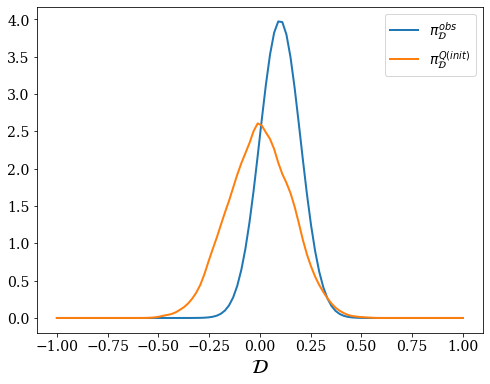

In [20]:
#### Use plot to show the difference between the pushforward of the init and the observed #####
plt.figure()
xx = np.linspace(-1,1,100)
plt.plot(xx,pdf_obs(xx),label="$\pi_{\mathcal{D}}^{obs}$")
plt.plot(xx,pfprior_dens(xx), label="$\pi_{\mathcal{D}}^{Q(init)}$")
plt.xlabel("$\mathcal{D}$")
plt.legend();
# fig.savefig("images/2obs_pushforward")

### Verify Assumption 2

In [21]:
def Meanr(n):
    if n==0:
        pfprior_sample = Qexact(lam1_seed,lam2_seed)
        r = pdf_obs(pfprior_sample)/pfprior_dens(pfprior_sample)
    else:
        pfprior_sample_n = Q(n,lam1_seed,lam2_seed)
        r = pdf_obs(pfprior_sample_n)/pfprior_dens_n(n,pfprior_sample_n)
    return np.mean(r)

Expect_r = np.zeros(6)
for i in range(6):
    Expect_r[i] = Meanr(i)

In [22]:
print('Expected ratio for verifying Assumption 2')
print(Expect_r[1:])

Expected ratio for verifying Assumption 2
[1.00179843 1.00179844 1.00197    1.00197    1.00197088]


### Verify Theorem 4.2

Print out Monte Carlo Approximation of $\|\pi_{\Lambda}^{u,n}(\lambda)-\pi_{\Lambda}^u(\lambda)\|_{L^2(\Lambda)} $ 

\begin{align*}
\|\pi_{\Lambda}^{u,n}(\lambda)-\pi_{\Lambda}^u(\lambda)\|^2_{L^2(\Lambda)} &= \int (\pi^i(\lambda))^2 (r_n(\lambda) - r(\lambda))^2\, d\mu_{\Lambda}\\
&= \mathbb{E}_i (\pi^i(\lambda)(r_n(\lambda) - r(\lambda))^2)\\
&\approx \frac{1}{N} \sum_{j=1}^N \pi^i(\lambda^{(j)})(r_n(\lambda^{(j)}) -r(\lambda^{(j)}) )^2
\end{align*}

In [23]:
##### Load data for Fig 5 #####
# Print out Monte Carlo Approximation of $\|\pi_{\Lambda}^{u,n}(\lambda)-\pi_{\Lambda}^u(\lambda)\|_{L^2(\Lambda)} $
init_eval = np.zeros(int(1E4))
for i in range(int(1E4)):
    init_eval[i] = norm.pdf(lam1_seed[i], loc=0.1, scale=0.1)*norm.pdf(lam2_seed[i], loc=0.1, scale=0.1)

r = np.zeros(int(1E4))
for i in range(proc_size):
    filename = os.path.join(os.getcwd(), "Data", "r_") + str(i) + ".mat" 
    partial_data = sio.loadmat(filename)
    r += partial_data['r'].reshape(int(1E4))

rn = np.zeros((6,int(1E4)))
for i in range(6):
    for j in range(proc_size):
        filename = os.path.join(os.getcwd(), "Data", "r")  + str(i+1) + '_' + str(j) + ".mat" 
        partial_data = sio.loadmat(filename)
        rn[i,:] += partial_data['r'].reshape(int(1E4))

In [24]:
error_Update = np.zeros(5)

for i in range(5):
    error_Update[i] = (np.mean(init_eval*(rn[i,:] - r)**2))**(1/2)

In [25]:
np.set_printoptions(linewidth=110) 
print('L^2 Error for Inverse Problem',end='\n\n')
print(error_Update)   

L^2 Error for Inverse Problem

[4.25879362e-01 4.25878780e-01 5.37649557e-03 5.37799511e-03 3.87794081e-04]


#### Figure 5

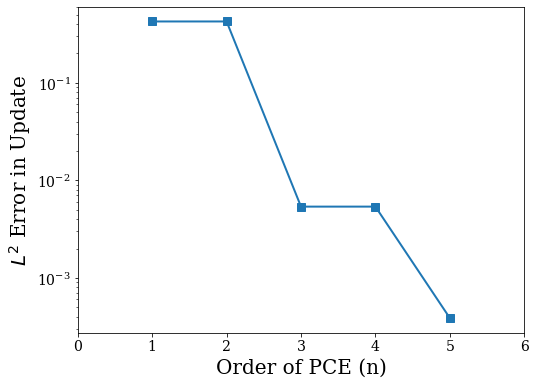

In [26]:
###########################################
################ Figure 5 #################
###########################################
fig = plt.figure()
plt.xlim([0,6])
plt.semilogy([1,2,3,4,5], error_Update, '-s')#, label='$L^2(\Lambda)$ error')
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^2$'+' Error in Update')
# fig.savefig("images/2inverse_error")
plt.savefig("images/Fig5")